In [1]:
import pandas as pd
import numpy as np
import pydotplus 
import io
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import misc
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
#from sklearn.model_selection import CridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline


url = 'https://raw.githubusercontent.com/firasm/PIMS-BCFSA/master/New_Sample_Clean_latest.csv'
#url ='https://raw.githubusercontent.com/shughestr/PIMS_2020_Real_Estate_data/master/sample_clean.csv'
  
df = pd.read_csv(url, error_bad_lines=False)
df=df.dropna()
# in this step, we removed 2 columns 
for col in df.columns:
    if len(df[col].unique())==1:
        df.drop(col,inplace=True,axis=1)


In [2]:
from itertools import product

def check_cardinality(df):

    combinations_lst = list(product(df.columns, df.columns))
    relations = ['one_to_one', 'one_to_many', 'many_to_one']

    output = []
    for col1, col2 in combinations_lst:
        for relation in relations:
            try:
                pd.merge(df[[col1]], df[[col2]], left_on=col1, right_on=col2, validate=relation)
                output.append([col1, col2, relation])
            except:
                continue

    return output


In [3]:
def get_relation(df, col1, col2):        
    first_max = df[[col1, col2]].groupby(col1).count().max()[0]
    second_max = df[[col1, col2]].groupby(col2).count().max()[0]
    if first_max==1:
        if second_max==1:
            return 'one-to-one'
        else:
            return 'one-to-many'
    else:
        if second_max==1:
            return 'many-to-one'
        else:
            return 'many-to-many'

from itertools import product
for col_i, col_j in product(df.columns, df.columns):
    if col_i == col_j:
        continue
    print(col_i, col_j, get_relation(df, col_i, col_j))

Unnamed: 0 ADDRESS one-to-many
Unnamed: 0 ASSESSED_VALUE one-to-many
Unnamed: 0 COMM_CODE one-to-many
Unnamed: 0 COMM_NAME one-to-many
Unnamed: 0 LATITUDE one-to-many
Unnamed: 0 LONGITUDE one-to-many
Unnamed: 0 ROLL_NUMBER one-to-many
Unnamed: 0 Year one-to-many
Unnamed: 0 location one-to-many
Unnamed: 0 fsa one-to-many
Unnamed: 0 pct_change one-to-many
Unnamed: 0 YEAR_OF_CONSTRUCTION one-to-many
Unnamed: 0 saf1 one-to-many
Unnamed: 0 saf2 one-to-many
Unnamed: 0 saf3 one-to-many
Unnamed: 0 saf4 one-to-many
Unnamed: 0 saf5 one-to-many
Unnamed: 0 saf6 one-to-many
Unnamed: 0 saf7 one-to-many
Unnamed: 0 saf8 one-to-many
Unnamed: 0 mr5y one-to-many
Unnamed: 0 Inflation one-to-many
Unnamed: 0 pop1 one-to-many
Unnamed: 0 pop2 one-to-many
Unnamed: 0 pop3 one-to-many
Unnamed: 0 pop4 one-to-many
Unnamed: 0 pop5 one-to-many
Unnamed: 0 pop6 one-to-many
Unnamed: 0 lan1 one-to-many
Unnamed: 0 lan2 one-to-many
Unnamed: 0 inc1 one-to-many
Unnamed: 0 inc2 one-to-many
Unnamed: 0 inc3 one-to-many
Unnamed

In [4]:
df['pct_change_bin']=pd.cut(df['pct_change'], bins=np.array([-0.12,-0.06, 0,0.06,0.12]),labels=range(0,4))
df=df.dropna()
df.keys()

Index(['Unnamed: 0', 'ADDRESS', 'ASSESSED_VALUE', 'COMM_CODE', 'COMM_NAME',
       'LATITUDE', 'LONGITUDE', 'ROLL_NUMBER', 'Year', 'location', 'fsa',
       'pct_change', 'YEAR_OF_CONSTRUCTION', 'saf1', 'saf2', 'saf3', 'saf4',
       'saf5', 'saf6', 'saf7', 'saf8', 'mr5y', 'Inflation', 'pop1', 'pop2',
       'pop3', 'pop4', 'pop5', 'pop6', 'lan1', 'lan2', 'inc1', 'inc2', 'inc3',
       'inc4', 'own1', 'own2', 'own3', 'own4', 'lab1', 'lab2', 'lab3',
       'vacancy_rate', 'walk_score_comm', 'transit_score_comm',
       'bike_score_comm', 'comm_polulation', 'pct_change_bin'],
      dtype='object')

In [5]:
df_num = df.drop(['Unnamed: 0','ADDRESS','COMM_CODE','COMM_NAME','location','fsa','comm_polulation'],axis=1)
from sklearn import preprocessing
x=df_num.drop(['ASSESSED_VALUE','pct_change','Year','pct_change_bin','ROLL_NUMBER'],axis=1).values
standard_scaler=preprocessing.StandardScaler()
x_scaled=standard_scaler.fit_transform(x)
df_scaled=pd.DataFrame(x_scaled,columns=df_num.drop(['ASSESSED_VALUE','pct_change','Year','pct_change_bin','ROLL_NUMBER'],axis=1).columns)
df_scaled[['ASSESSED_VALUE','pct_change','pct_change_bin']]=df_num[['ASSESSED_VALUE','pct_change','pct_change_bin']]
df_scaled=df_scaled.dropna()




Text(0, 0.5, 'cumulative explained variance')

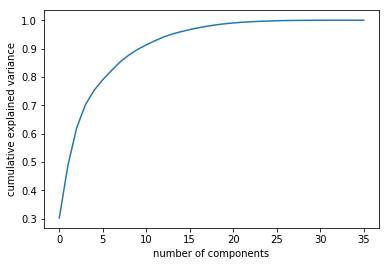

In [6]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_scaled.drop(['ASSESSED_VALUE','pct_change','pct_change_bin'],axis=1).values)
ratio=np.cumsum(pca.explained_variance_ratio_)
plt.plot(ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
df_scaled1=df_num.drop(['Year','ROLL_NUMBER'],axis=1)
df_scaled1['Age']=2020-df_scaled1['YEAR_OF_CONSTRUCTION']
df_scaled=df_scaled1.drop(['YEAR_OF_CONSTRUCTION'],axis=1)
x_train, x_test, y_train, y_test=train_test_split(df_scaled.drop(['ASSESSED_VALUE','pct_change'],axis=1),df_scaled['pct_change'],test_size=0.2,random_state=0)

In [8]:
from sklearn.linear_model import LinearRegression
L=LinearRegression()
L.fit(x_train.drop(['pct_change_bin'],axis=1),y_train)




y_pred1=L.predict(x_test.drop(['pct_change_bin'],axis=1))

from sklearn.metrics import r2_score, mean_squared_error

print('R2 score', r2_score(y_test,y_pred1))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred1)))

R2 score 0.34553249771304273
RMSE 0.03325795962893804


/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.91965217045614, tolerance: 0.0019615215316853905
  positive)


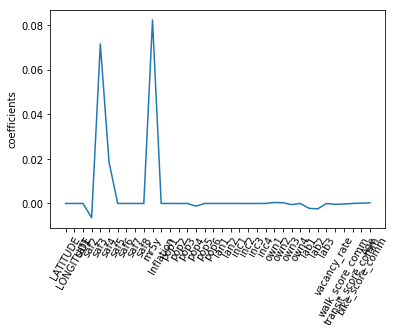

In [9]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.0001,normalize=False)
lasso_coef=lasso.fit(x_train.drop(['pct_change_bin'],axis=1),y_train).coef_
_=plt.plot(range(len(x_train.drop(['pct_change_bin'],axis=1).columns)),lasso_coef)
names=x_train.drop(['pct_change_bin'],axis=1).columns
_=plt.xticks(range(len(names)),names,rotation=60)
_=plt.ylabel("coefficients")
plt.show()

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
model_lasso = LassoCV(alphas = [0.0001]).fit(x_train.drop(['pct_change_bin'],axis=1),y_train)

coef_lasso = pd.Series(model_lasso.coef_, index = names)
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.59486232030327, tolerance: 0.001567417447254166
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.556328994601082, tolerance: 0.0015746291192930955
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.430781679101105, tolerance: 0.0015485785864857412
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

Lasso picked 22 variables and eliminated the other 14 variables


/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.91965217045614, tolerance: 0.0019615215316853905
  positive)


/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4121860106186785, tolerance: 0.001567417447254166
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.381002284260195, tolerance: 0.0015746291192930955
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2478864811149295, tolerance: 0.0015485785864857412
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate

0.0011478526628535967


/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.693725219860691, tolerance: 0.0019615215316853905
  positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.59486232030327, tolerance: 0.001567417447254166
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.556328994601082, tolerance: 0.0015746291192930955
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: Conv

0.0011388042986313642

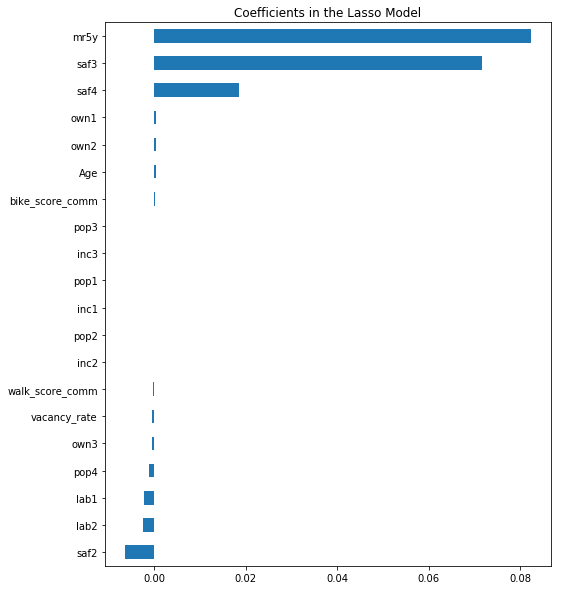

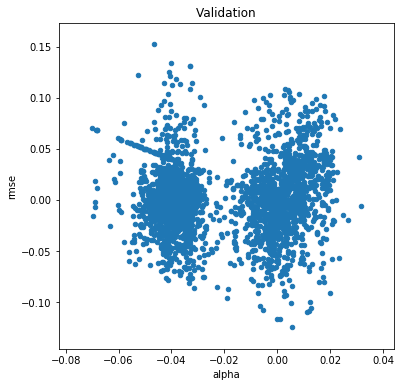

In [11]:
imp_coef = pd.concat([coef_lasso.sort_values().head(10),
                     coef_lasso.sort_values().tail(10)])
#imp_coef = pd.concat([coef_lasso.sort_values()])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(x_test.drop(['pct_change_bin'],axis=1)), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

y_pred2 = model_lasso.predict(x_test.drop(['pct_change_bin'],axis=1))           
print(mean_squared_error(y_test, y_pred2))    

alphas = [0.00001,0.0001,0.001,0.01]
cv_lasso = []
for alpha in alphas:
    model_lasso = LassoCV(alphas = [alpha]).fit(x_train.drop(['pct_change_bin'],axis=1),y_train)
    y_pred3 = model_lasso.predict(x_test.drop(['pct_change_bin'],axis=1))
    cv_lasso.append(mean_squared_error(y_test, y_pred3))
    
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse") 
cv_lasso.min()

Ridge picked 36 variables and eliminated the other 0 variables
0.003049310280037793


0.0011079490290819942

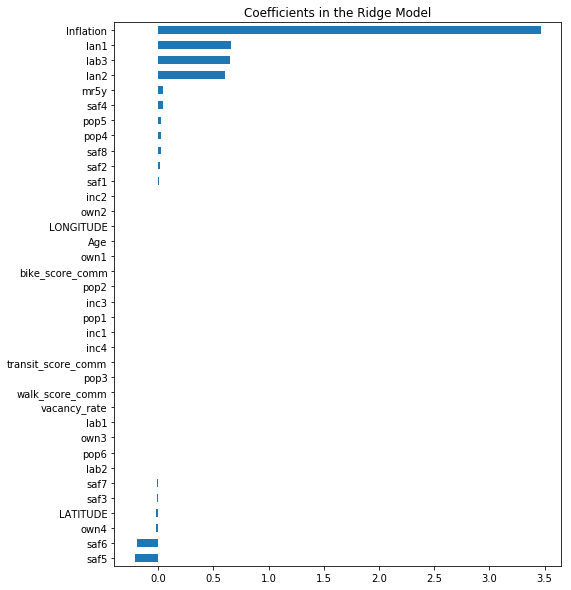

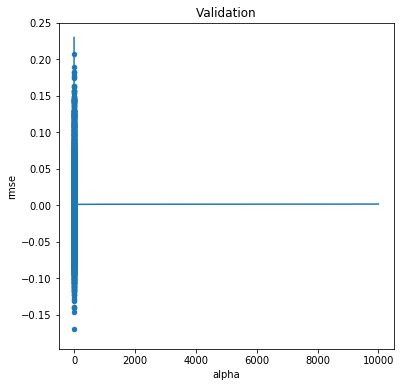

In [12]:
model_Ridge = RidgeCV(alphas = [0.0001]).fit(x_train.drop(['pct_change_bin'],axis=1),y_train)

coef_Ridge = pd.Series(model_Ridge.coef_, index = names)
print("Ridge picked " + str(sum(coef_Ridge != 0)) + " variables and eliminated the other " +  str(sum(coef_Ridge == 0)) + " variables")

imp_coef = pd.concat([coef_Ridge.sort_values()])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds_r = pd.DataFrame({"preds":model_Ridge.predict(x_test.drop(['pct_change_bin'],axis=1)), "true":y_test})
preds_r["residuals"] = preds_r["true"] - preds_r["preds"]
preds_r.plot(x = "preds", y = "residuals",kind = "scatter")

y_pred3 = model_Ridge.predict(x_test.drop(['pct_change_bin'],axis=1))           
print(mean_squared_error(y_test, y_pred3))    


alphas = [0.00001,0.0001,0.001,0.01, 0.1, 1, 10,100,1000,10**4]
cv_ridge = []
for alpha in alphas:
    model_Ridge = RidgeCV(alphas = [alpha]).fit(x_train.drop(['pct_change_bin'],axis=1),y_train)
    y_pred3 = model_Ridge.predict(x_test.drop(['pct_change_bin'],axis=1))
    cv_ridge.append(mean_squared_error(y_test, y_pred3))
    
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse") 
cv_ridge.min()

/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.859231050609241, tolerance: 0.0019615215316853905
  positive)


ElasticNet picked 20 variables and eliminated the other 16 variables
0.0011478990626297223


/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.669839288086552, tolerance: 0.0019615215316853905
  positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.859231050609241, tolerance: 0.0019615215316853905
  positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.490886017806516, tolerance: 0.0019615215316853905
  positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

0.0011079490290819942

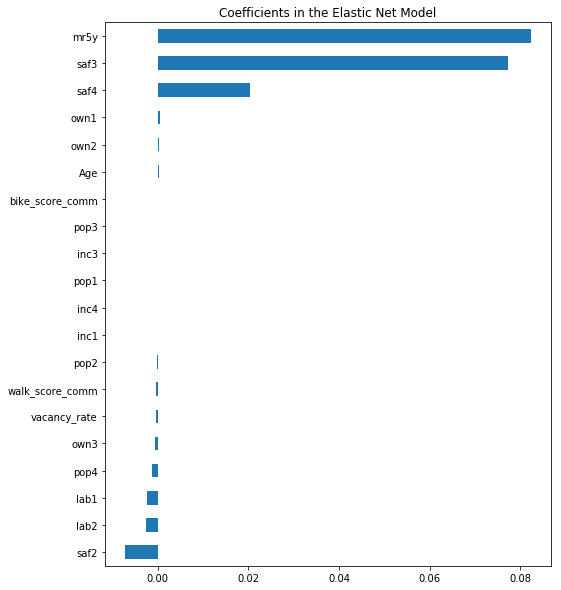

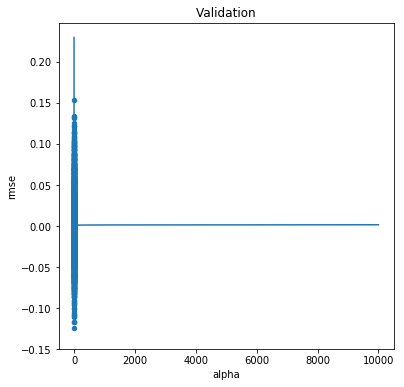

In [13]:
model_elastic=ElasticNet(alpha = [0.0001],l1_ratio=0.7).fit(x_train.drop(['pct_change_bin'],axis=1),y_train)


coef_elastic = pd.Series(model_elastic.coef_, index = names)
print("ElasticNet picked " + str(sum(coef_elastic != 0)) + " variables and eliminated the other " +  str(sum(coef_elastic == 0)) + " variables")

imp_coef = pd.concat([coef_elastic.sort_values().head(10),
                     coef_elastic.sort_values().tail(10)])
#imp_coef = pd.concat([coef_lasso.sort_values()])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_elastic.predict(x_test.drop(['pct_change_bin'],axis=1)), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

y_pred4 = model_elastic.predict(x_test.drop(['pct_change_bin'],axis=1))           
print(mean_squared_error(y_test, y_pred4))    



alphas = [0.00001,0.0001,0.001,0.01, 0.1, 1, 10,100,1000,10**4]
cv_elastic = []
for alpha in alphas:
    model_elastic = ElasticNet(alpha = [alpha],l1_ratio=0.7).fit(x_train.drop(['pct_change_bin'],axis=1),y_train)
    y_pred3 = model_elastic.predict(x_test.drop(['pct_change_bin'],axis=1))
    cv_elastic.append(mean_squared_error(y_test, y_pred3))
    
cv_elastic = pd.Series(cv_ridge, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse") 
cv_elastic.min()

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


clf = LinearRegression()

# Build step forward feature selection
sfs1 = sfs(clf,k_features = 15,forward=True,floating=False, scoring='r2',cv=15)

# Perform SFFS
sfs1 = sfs1.fit(x_train.drop(['pct_change_bin'],axis=1),y_train)
feat_cols = list(sfs1.k_feature_idx_)
x_train.drop(['pct_change_bin'],axis=1).columns[feat_cols]

Index(['LATITUDE', 'LONGITUDE', 'saf4', 'saf5', 'saf8', 'mr5y', 'Inflation',
       'pop1', 'pop2', 'inc3', 'own3', 'own4', 'lab1', 'walk_score_comm',
       'Age'],
      dtype='object')

In [15]:
import statsmodels.api as sm
y_o=y_train
X_o=x_train.drop(['pct_change_bin'],axis=1)

#Fitting sm.OLS model
model = sm.OLS(y_o,X_o.astype(float)).fit()
model.pvalues

cols = list(X_o.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_o[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_o,X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE[0:15])

/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


['LATITUDE', 'saf2', 'saf3', 'saf4', 'saf5', 'saf6', 'saf7', 'saf8', 'mr5y', 'Inflation', 'pop1', 'pop2', 'pop3', 'pop4', 'pop5']


In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

y_o=y_train
X_o=x_train.drop(['pct_change_bin'],axis=1)

#X_o = sc.fit_transform(X_r)
fvalue_selector = SelectKBest(f_regression,k=15)
X_kbest = fvalue_selector.fit_transform(X_o, y_o)
fvalue_selector.get_support([X_o.shape[1]])
#X_new = fvalue_selector.transform(X_o)
X_o.columns[fvalue_selector.get_support(indices=True)]

Index(['saf3', 'saf4', 'saf5', 'saf7', 'mr5y', 'Inflation', 'pop4', 'pop5',
       'inc2', 'inc3', 'lab1', 'lab3', 'walk_score_comm', 'transit_score_comm',
       'Age'],
      dtype='object')

In [17]:
from collections import Counter
Features=['LATITUDE', 'LONGITUDE', 'saf4', 'saf5', 'saf8', 'mr5y', 'Inflation',
       'pop1', 'pop2', 'inc3', 'own3', 'own4', 'lab1', 'walk_score_comm',
       'Age',
         'LATITUDE', 'saf2', 'saf3', 'saf4', 'saf5', 'saf6', 'saf7', 'saf8', 'mr5y', 'Inflation', 'pop1', 'pop2', 'pop3', 'pop4', 'pop5', 'pop6', 'lan1', 'lan2', 'inc1', 'inc2', 'inc3', 'own2', 'own3', 'own4', 'lab2', 'lab3', 'vacancy_rate', 'walk_score_comm', 'Age',
         'saf3', 'saf4', 'saf5', 'saf7', 'mr5y', 'Inflation', 'pop4', 'pop5',
       'inc2', 'inc3', 'lab1', 'lab3', 'walk_score_comm', 'transit_score_comm',
       'Age',
        'saf2', 'saf3', 'saf4', 'mr5y', 'pop1', 'pop2', 'pop3', 'pop4', 'inc1',
       'inc2', 'inc3', 'inc4', 'own1', 'own2', 'own3', 'lab1', 'lab2',
       'vacancy_rate', 'walk_score_comm', 'transit_score_comm',
       'bike_score_comm', 'Age',
        'saf2', 'saf3', 'saf4', 'mr5y', 'pop1', 'pop2', 'pop3', 'pop4', 'inc1',
       'inc3', 'inc4', 'own1', 'own2', 'own3', 'lab1', 'lab2', 'vacancy_rate',
       'walk_score_comm', 'bike_score_comm', 'Age' ]


Counter(Features)

Counter({'LATITUDE': 2,
         'LONGITUDE': 1,
         'saf4': 5,
         'saf5': 3,
         'saf8': 2,
         'mr5y': 5,
         'Inflation': 3,
         'pop1': 4,
         'pop2': 4,
         'inc3': 5,
         'own3': 4,
         'own4': 2,
         'lab1': 4,
         'walk_score_comm': 5,
         'Age': 5,
         'saf2': 3,
         'saf3': 4,
         'saf6': 1,
         'saf7': 2,
         'pop3': 3,
         'pop4': 4,
         'pop5': 2,
         'pop6': 1,
         'lan1': 1,
         'lan2': 1,
         'inc1': 3,
         'inc2': 3,
         'own2': 3,
         'lab2': 3,
         'lab3': 2,
         'vacancy_rate': 3,
         'transit_score_comm': 2,
         'inc4': 2,
         'own1': 2,
         'bike_score_comm': 2})

In [18]:
feature_selected=['saf4','saf5','mr5y','Inflation','pop1','pop2','inc3','own3','lab1','walk_score_comm','Age','saf2','saf3','pop3','pop4','inc1','inc2','own2','lab2','vacancy_rate']

x_train2=x_train[feature_selected]
x_test2=x_test[feature_selected]
y_train_tree=x_train['pct_change_bin']
y_test_tree=x_test['pct_change_bin']

In [19]:
from sklearn.linear_model import LinearRegression
L=LinearRegression()
L.fit(x_train2,y_train)




y_pred1=L.predict(x_test2)

from sklearn.metrics import r2_score, mean_squared_error

print('R2 score', r2_score(y_test,y_pred1))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred1)))

R2 score 0.33721289778533003
RMSE 0.03346867989505612


/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


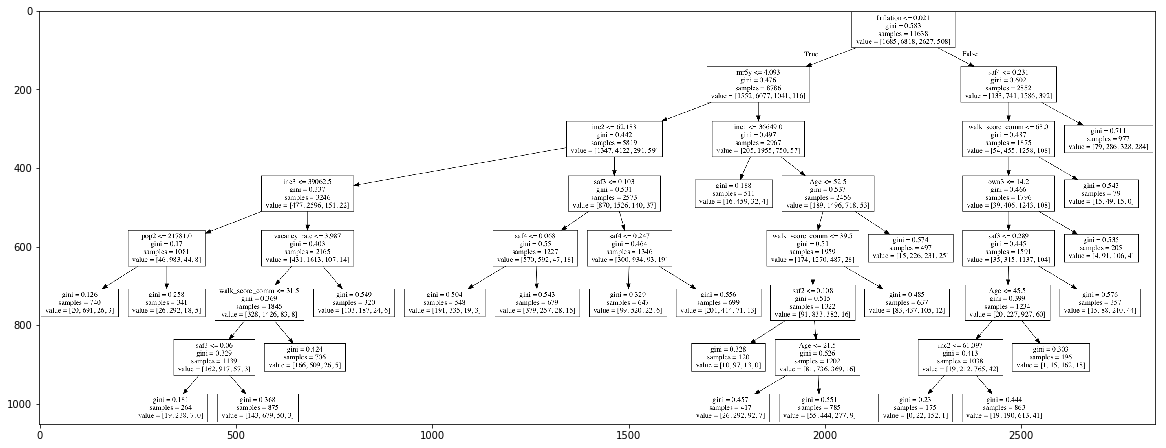

In [20]:
c=DecisionTreeClassifier(min_samples_split=1000)
dt=c.fit(x_train2, y_train_tree)
def show_tree(tree, features, path):
    f=io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img=misc.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)
    
show_tree(dt,feature_selected,"dec_tree_02.png")



Accuracy using Decision Tree: 66.8 %


Text(69.0, 0.5, 'Truth')

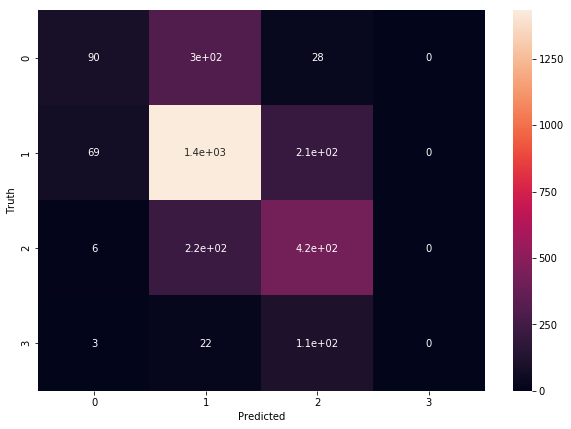

In [21]:
y_pred_tree1=c.predict(x_test2)
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test_tree,y_pred_tree1)*100
print("Accuracy using Decision Tree:", round(score, 1),"%")

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_tree,y_pred_tree1)
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [22]:
from sklearn.ensemble import RandomForestClassifier

model_rf=RandomForestClassifier(n_estimators=1000)
model_rf.fit(x_train2, y_train_tree)
model_rf.score(x_test2, y_test_tree)

y_pred_rf=model_rf.predict(x_test2)
score_rf=accuracy_score(y_test_tree,y_pred_rf)*100
print("Accuracy using Decision Tree:", round(score_rf, 1),"%")



Accuracy using Decision Tree: 68.1 %


Text(69.0, 0.5, 'Truth')

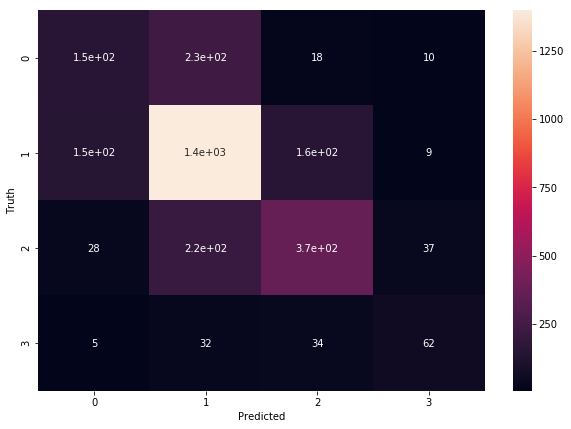

In [23]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_tree,y_pred_rf)
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

GB_classifier=GradientBoostingClassifier()
GB_classifier.fit(x_train2, y_train_tree)

y_pred_g=GB_classifier.predict(x_test2)

print("Accuracy of Model:",accuracy_score(y_test_tree,y_pred_g))



Accuracy of Model: 0.7


In [25]:
xgb_classifier=xgb.XGBClassifier(objective='multi:softprob')
xgb_classifier.fit(x_train2, y_train_tree)
y_pred_x=xgb_classifier.predict(x_test2)

print("Accuracy of Model:",accuracy_score(y_test_tree,y_pred_x))


Accuracy of Model: 0.6979381443298969


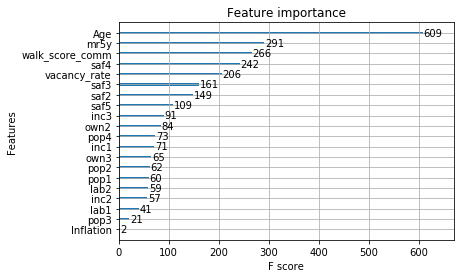

In [26]:
xgb.plot_importance(xgb_classifier)

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.show()



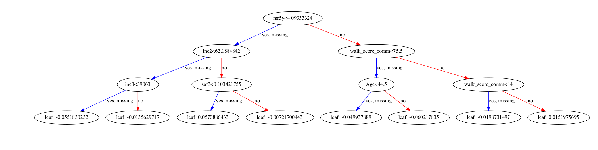

In [27]:
xgb.plot_tree(xgb_classifier,num_trees=0)
plt.rcParams['figure.figsize']=[5,5]
#plt.show()
plt.savefig("xgboost_tree2.png", bbox_inches='tight', dpi=400)

[Text(0, 0.5, '[-0.12  -0.06)'),
 Text(0, 1.5, '[-0.06  0)'),
 Text(0, 2.5, '[0  0.06)'),
 Text(0, 3.5, '[0.06  0.12]')]

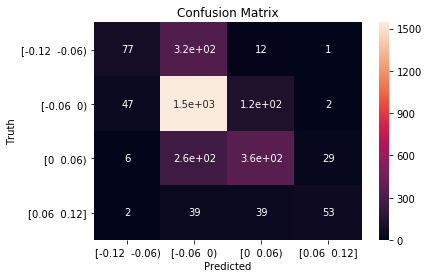

<Figure size 720x720 with 0 Axes>

In [28]:
cm=confusion_matrix(y_test_tree,y_pred_x)
%matplotlib inline
ax=plt.subplot()
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Truth")
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['[-0.12  -0.06)','[-0.06  0)','[0  0.06)','[0.06  0.12]'])
ax.xaxis.set_ticklabels(['[-0.12  -0.06)','[-0.06  0)','[0  0.06)','[0.06  0.12]'])
ax.set_yticklabels(ax.get_xticklabels(), rotation=0, ha='right')